In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys,pickle,glob
from tqdm import tqdm_notebook as tq
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from collections import Counter
from IPython.core.display import display
#from pathos import multiprocessing as mp

from matplotlib import pyplot as plt
import seaborn
colors = seaborn.color_palette()
xr_full = range(1991,2016)
xr = range(1992,2016)
%matplotlib inline

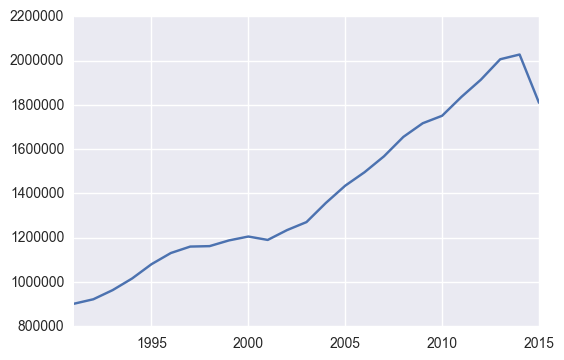

In [71]:
#trimmed = cat_pubs_by_year[[c for c in cat_pubs_by_year.columns if c!='ALL']]
#trimmed.sum(1).plot()
cat_pubs_by_year.ALL.plot()

In [92]:
#DATADIR = '../results/'
DATADIR = '/Users/jaredlorince/Desktop/'
files = glob.glob(DATADIR+'by-cat-results/results*')
cats = set([f[f.rfind('_')+1:] for f in files])
print(sorted(cats))

[]


In [4]:
cat_pubs_by_year = pd.read_pickle(DATADIR+'cat_pubs_by_year.pkl')

In [5]:
props = cat_pubs_by_year.divide(cat_pubs_by_year['ALL'],axis=0)
growth = np.log10(props/props.shift(1))

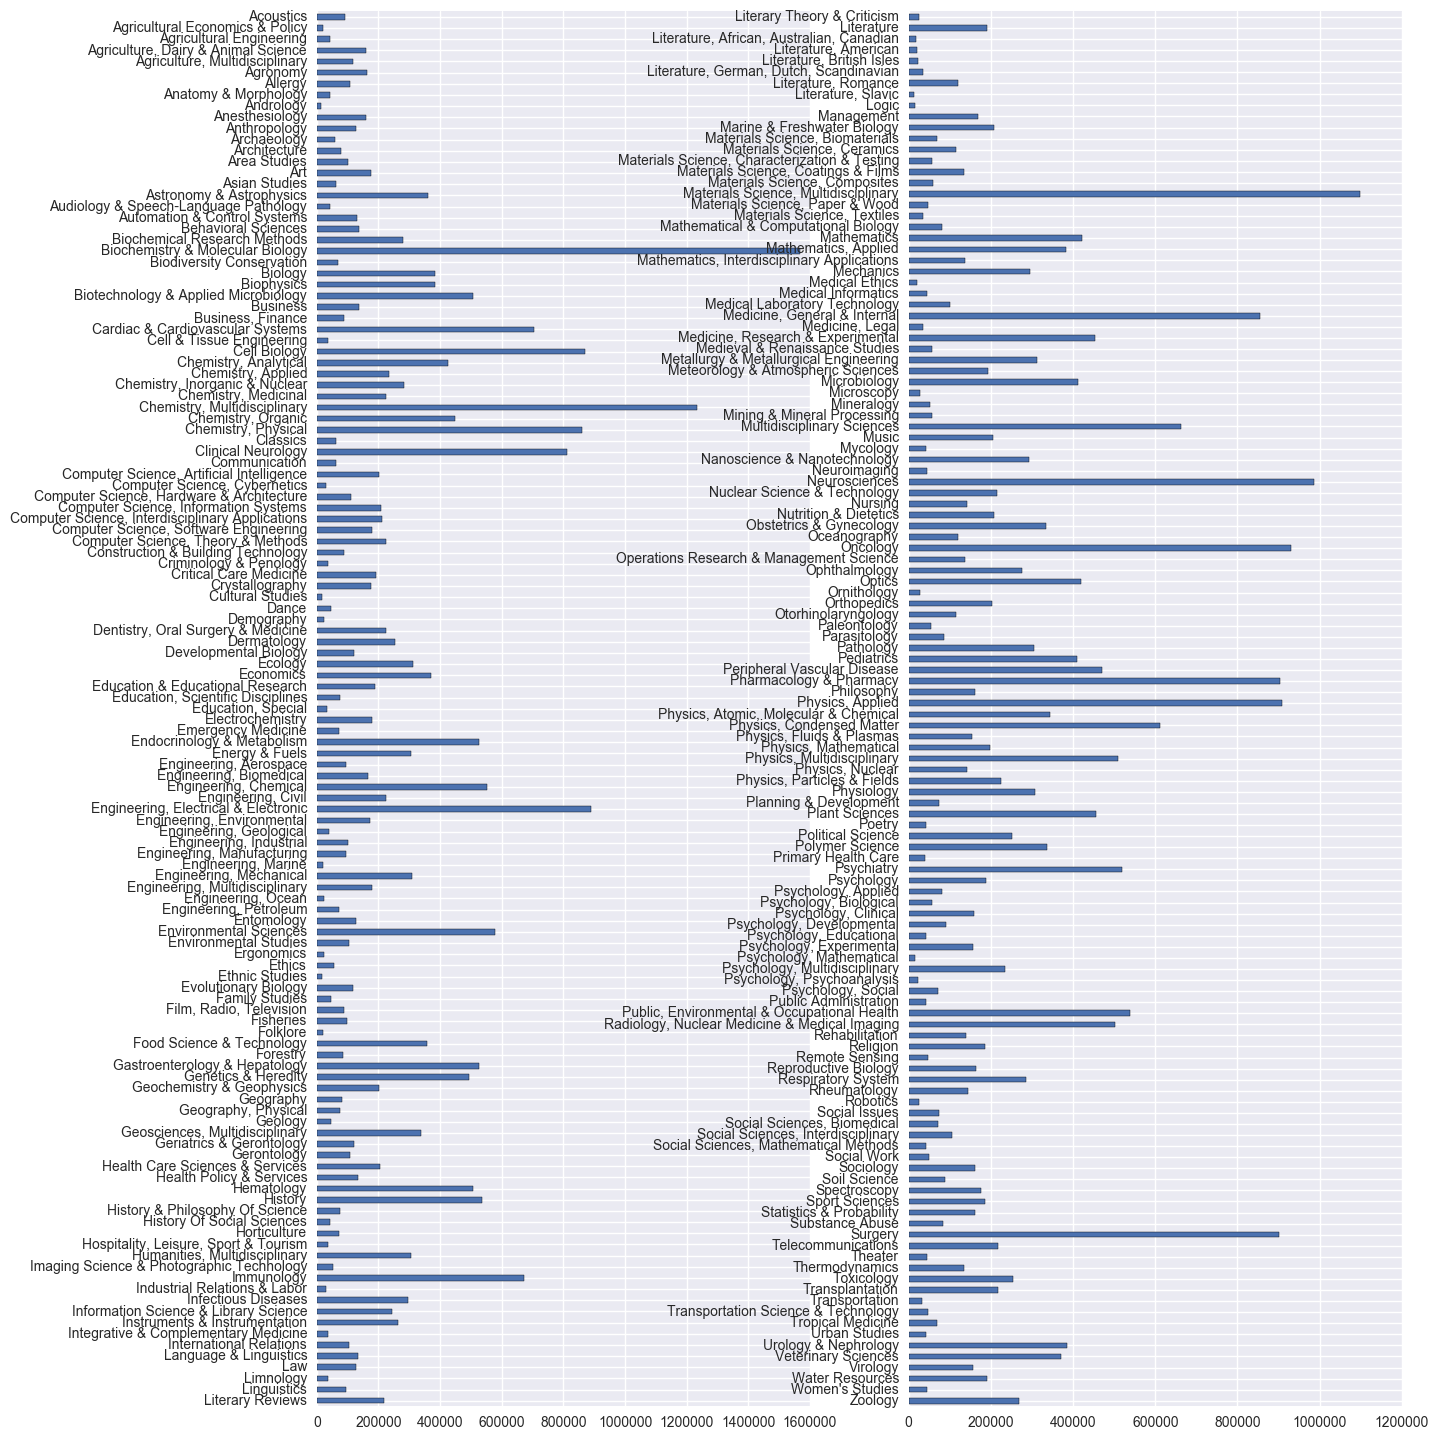

In [66]:
#just a big bar plot of the overall number of pubs for each field
fig,axes = plt.subplots(1,2,figsize=(14,18))
mx = cat_pubs_by_year.sum(0)[:-1].max()
cat_pubs_by_year.sum(0)[:125][::-1].plot(kind='barh',ax=axes[0],ylim=(0,mx))
cat_pubs_by_year.sum(0)[125:-1][::-1].plot(kind='barh',ax=axes[1],ylim=(0,mx));

In [7]:
def growth(cat,window):
    mx = len(cat_pubs_by_year)-(2*window-1)
    result = []
    for i in range(mx):
        a = cat_pubs_by_year[cat][i:i+window].sum()
        aprop = a/cat_pubs_by_year['ALL'][i:i+window].sum()
        b = cat_pubs_by_year[cat][i+window:i+window*2].sum()
        bprop = b/cat_pubs_by_year['ALL'][i+window:i+window*2].sum()
        result.append(np.log(bprop/aprop))    
    return np.array(result)

In [8]:
def parse_results(fi):
    df =  pd.read_table(fi,header=None,names=['measure','data'],index_col='measure')
    df.data = df.data.apply(lambda x: np.array(x.split(','),dtype=float))
    return df

In [99]:
colors = seaborn.color_palette()
def plotter(cat,window_size,mode='local'):
    #df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    df = parse_results("{}results_{}_{}".format(DATADIR,window_size,cat))
    start = 1991+window_size-.5
    r = np.arange(start,start+len(df.ix['jsds'][0]))
    if window_size%2==0:
        r2 = np.arange(1991,1991+len(df.ix['ents'][0]))
    else:
        r2 = np.arange(start,start+len(df.ix['ents'][0]))

    fig,axes = plt.subplots(1,4,figsize=(16,4))
    
    ax = axes[0]
    ax.plot(r,df.ix['jsds'][0],label='JSD (raw)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0],label=r'$\Delta H$ (raw)',color=colors[1])
    ax.plot(r,df.ix['jsd-null_m'][0],label='JSD (null)',c=colors[0],ls='--')
    ax.plot(r,df.ix['entdif-null_m'][0],label=r'$\Delta H$ (null)',color=colors[1],ls='--')
    #ax.fill_between(r,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.legend(loc='lower right',fontsize='medium')
    ax.set_title('Change measures')

    ax = axes[1]
    ax.plot(r2,df.ix['ents'][0],label='H (raw)')
    if mode == 'global':
        ax.plot(r2,df.ix['entropy-null_m'][0],label='H (null)',color=colors[1])
        ax.fill_between(r2,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.set_title('Entropy')
    ax.legend(loc='lower right')
    
    ax = axes[2]
    ax.plot(r,growth(cat,window_size),label='Growth')
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.set_title('Growth')
    
    ax = axes[3]
    ax.plot(r,df.ix['jsds'][0]-df.ix['jsd-null_m'][0],label='JSD (corrected)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0],label=r'$\Delta H$ (corrected)',color=colors[1])
    ax.legend(loc='upper right')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
    ax.set_title('Corrected measures')
    
    fig.suptitle(cat)
    

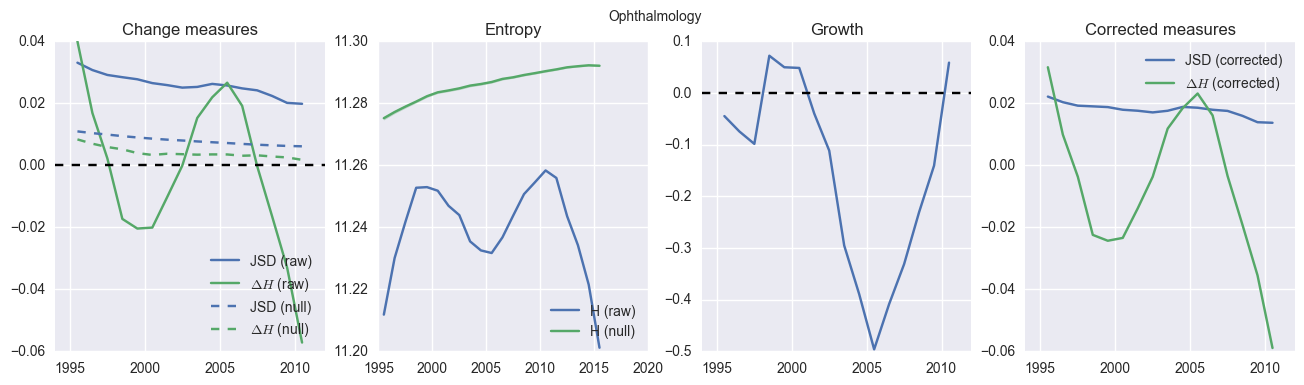

In [80]:
plotter('Ophthalmology',5)

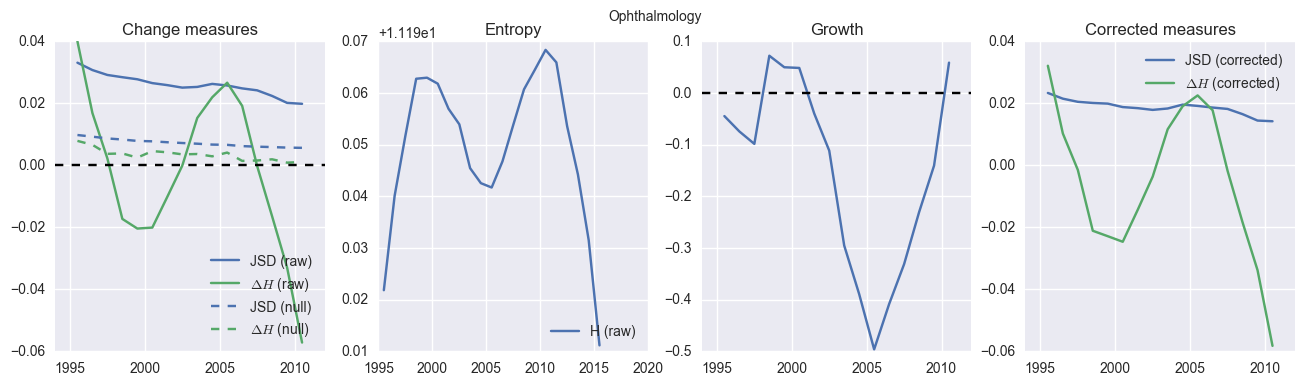

In [100]:
plotter('Ophthalmology',5)

In [77]:
def normalize(arr):
    a = arr.copy()
    if a.min()<0:
        a += abs(a.min())
    a = a / a.max()
    return a

delta_h = []
g = []
for cat in tq(cats):
    df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    current_growth = np.mean(growth(cat,window_size))
    #if np.all(np.abs(current_growth)>0):
    delta_h += list(np.mean(df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0]))
    g += list(current_growth)


TypeError: 'numpy.float64' object is not iterable

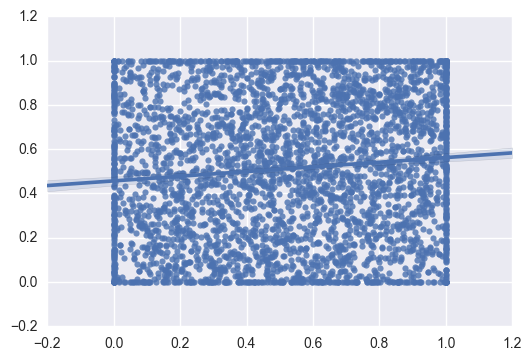

In [57]:
seaborn.regplot(x=np.array(delta_h),y=np.array(g))

In [64]:
cat_pubs_by_year['Literary Reviews'].sum()

217142.0

In [65]:
cat_pubs_by_year['Robotics'].sum()

25438.0